# Basic Exploratory Data Analysis
## Prerequisites
- Install Python 3



In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Disable the specific warning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
# Load Feature File
df = pd.read_csv("../TeamSeasons_cust.csv")

## Basic Seed Exploration

In [3]:
tourney_teams = df[df['Seed'].notna()]

In [4]:
round_num_map = {
    "Play In": 0,
    "First Round": 0,
    "Second Round": 1,
    "Sweet Sixteen": 2,
    "Elite Eight": 3,
    "Final Four": 4,
    "Championship": 5,
    "Champion": 6
}
perf_map = {k: v/6 for k, v in round_num_map.items()}
tourney_teams["RoundWinsNum"] = tourney_teams["ExitRound"].map(round_num_map)
tourney_teams["Performance"] = tourney_teams["ExitRound"].map(perf_map)
tourney_teams["Performance"] = tourney_teams["Performance"].fillna(0)

In [5]:
seed_exp_perf = {
    1: 4.75, # Two lose the final four, one lose in championship, one win the championship
    2: 3, # Make the Elite Eight
    3: 2, 4: 2, # Make the Sweet Sixteen
    5: 1, 6: 1, 7: 1, 8: 1, # Make the Second Round
    9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0 # Lose the First Round
}
seed_historical_perf = {}

         ExitRound  Seed  RoundWinsNum
7126   First Round   1.0           0.0
5456   First Round   1.0           0.0
2910  Second Round   1.0           1.0
7026  Second Round   1.0           1.0
3482  Second Round   1.0           1.0
...            ...   ...           ...
3169      Champion   1.0           6.0
4983      Champion   1.0           6.0
1783      Champion   1.0           6.0
6207      Champion   1.0           6.0
1402      Champion   1.0           6.0

[80 rows x 3 columns]
         ExitRound  Seed  RoundWinsNum
3203   First Round   2.0           0.0
4597   First Round   2.0           0.0
6672   First Round   2.0           0.0
6396   First Round   2.0           0.0
6902   First Round   2.0           0.0
...            ...   ...           ...
2161  Championship   2.0           5.0
127   Championship   2.0           5.0
1272  Championship   2.0           5.0
382       Champion   2.0           6.0
4753      Champion   2.0           6.0

[80 rows x 3 columns]
         ExitRound

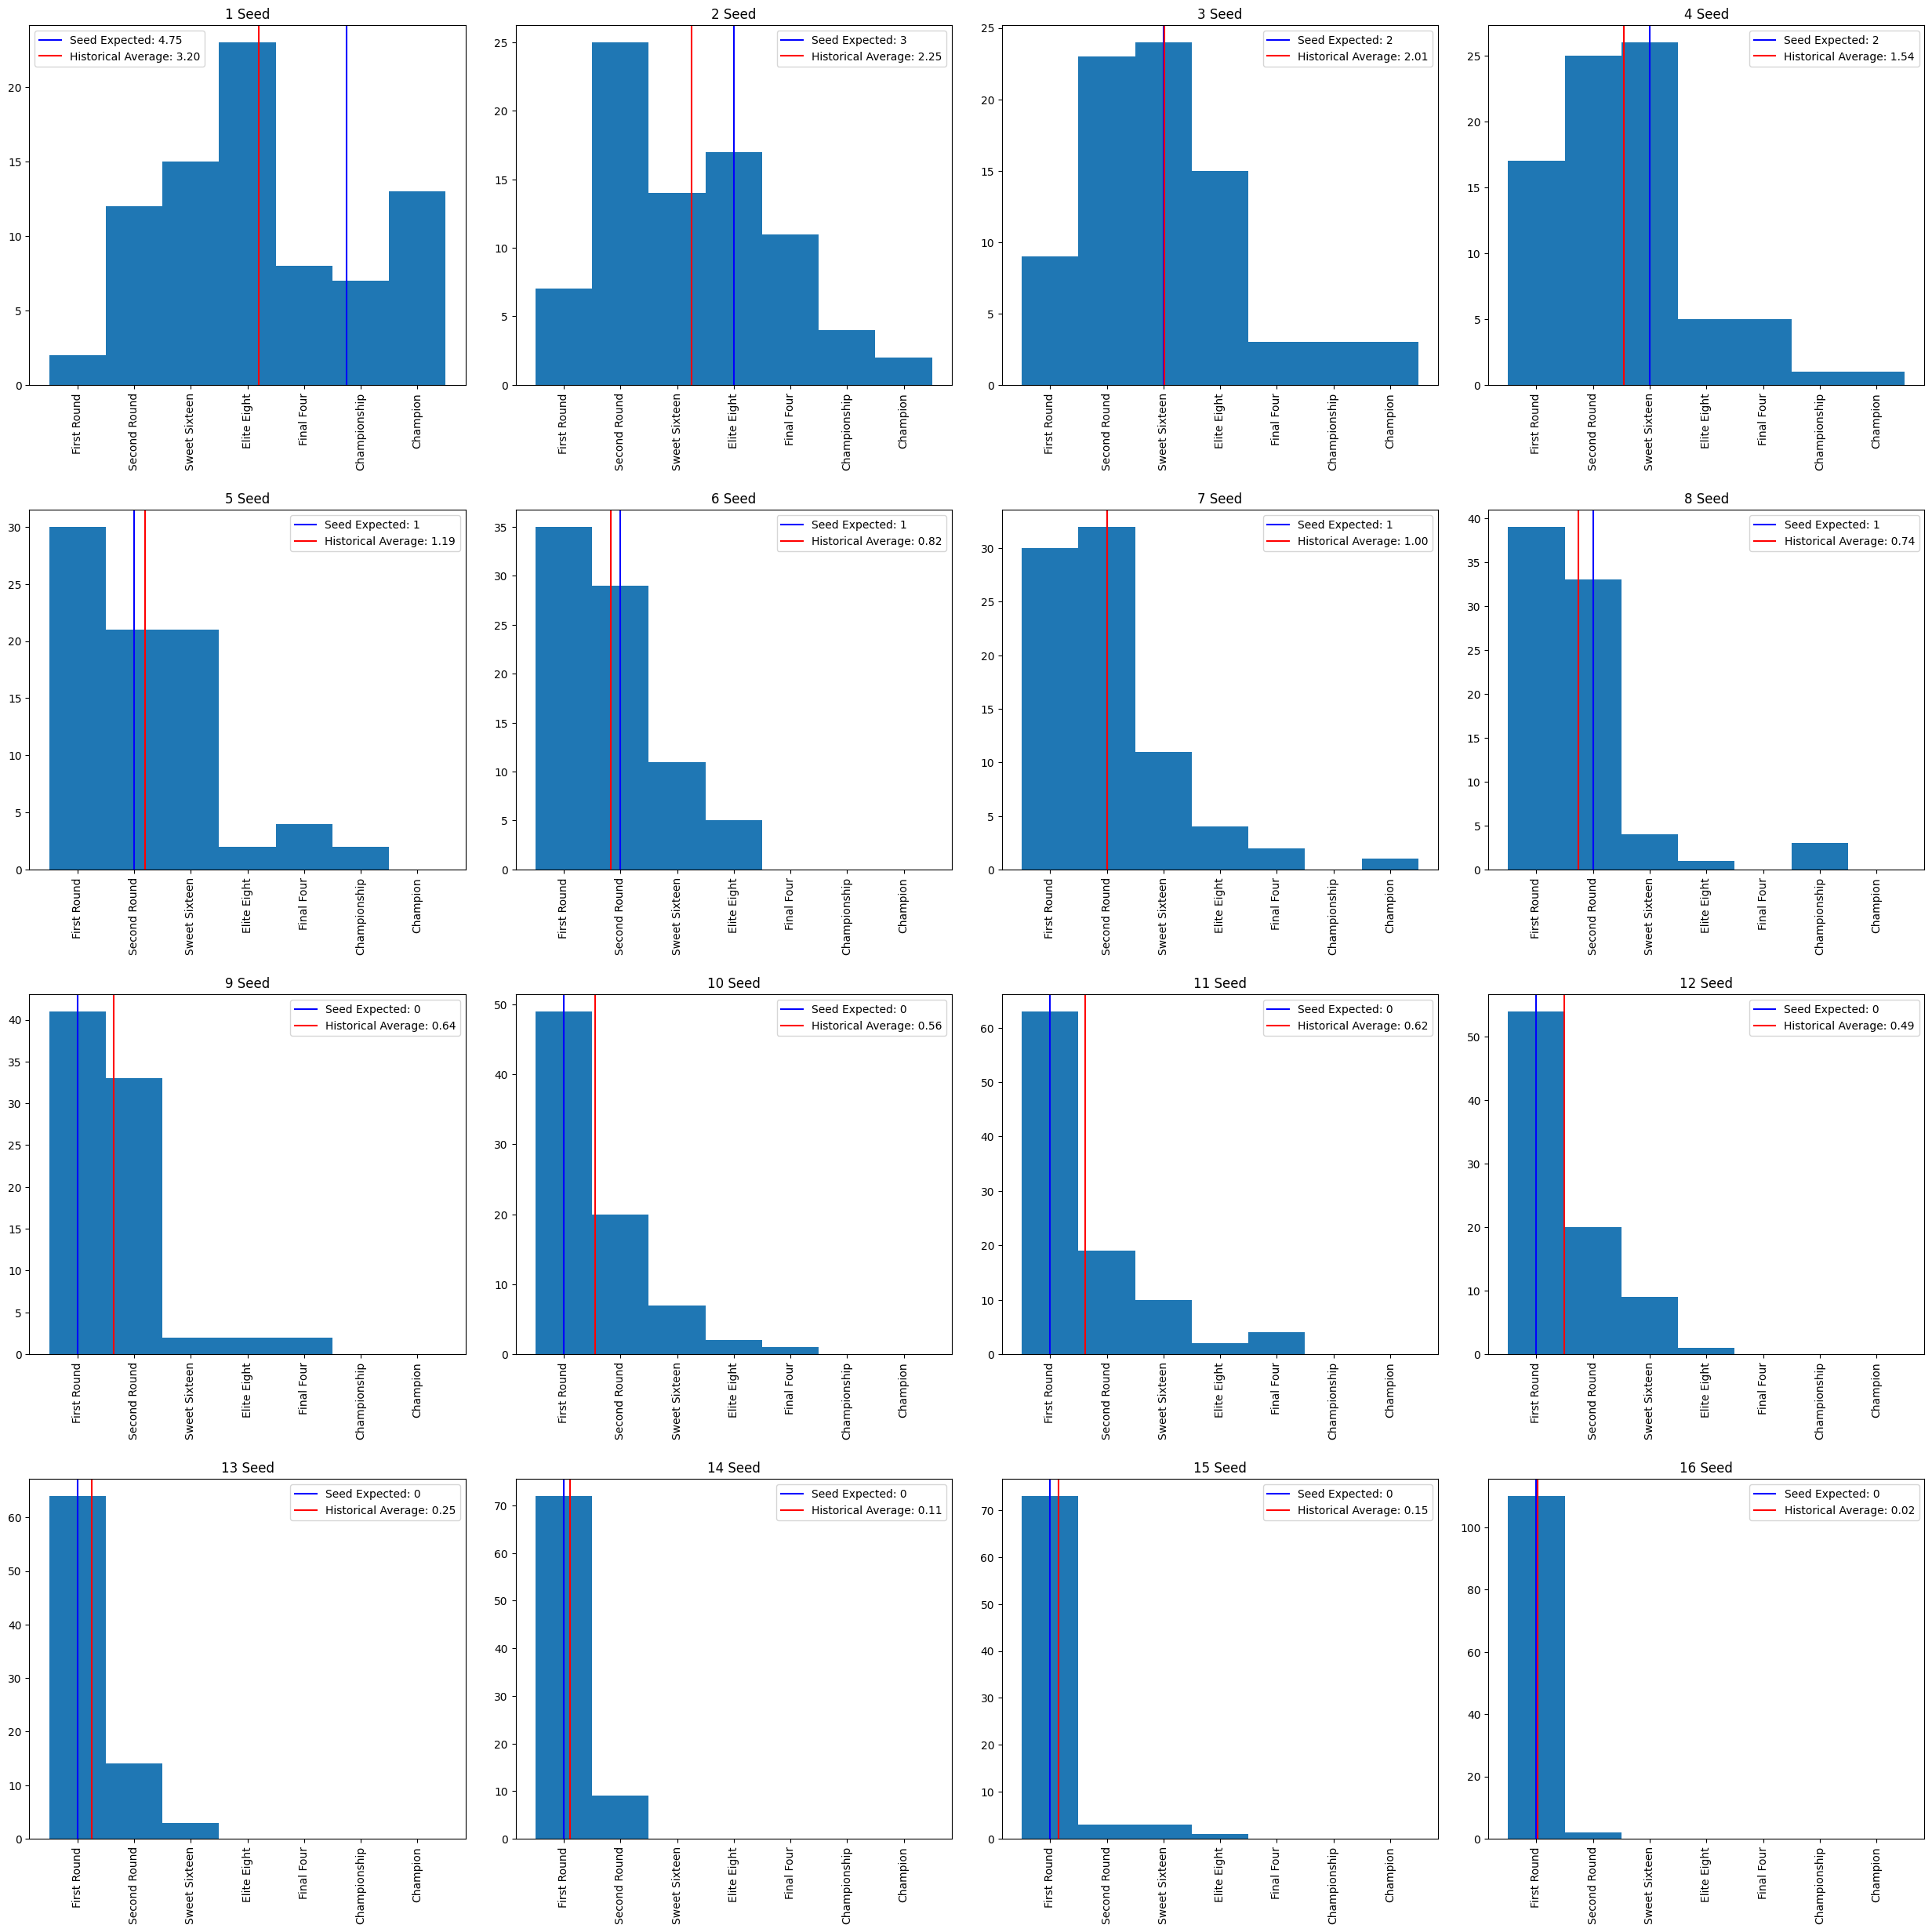

In [29]:
BIN_OFFSET = 0.5
fig, ax = plt.subplots(4, 4, figsize=(25, 25))
ax = ax.flatten()
for seed, seed_df in tourney_teams[["ExitRound", "Seed", "RoundWinsNum"]].groupby("Seed"):
    seed_axis = ax[int(seed) - 1]
    seed_df = seed_df.sort_values(["RoundWinsNum"])
    print(seed_df)
    n, bins, patches = seed_axis.hist(seed_df["RoundWinsNum"], bins=range(0, 8))
    hist_avg = sum([count * rnd for count, rnd in zip(n, bins)]) / sum(n)
    seed_historical_perf[int(seed)] = hist_avg       
    seed_axis.set_title(f"{int(seed)} Seed")
    seed_axis.axvline(x = seed_exp_perf[int(seed)] + BIN_OFFSET, color = 'b', label = f'Seed Expected: {seed_exp_perf[int(seed)]}')
    seed_axis.axvline(x = hist_avg + BIN_OFFSET, color = 'r', label = f'Historical Average: {hist_avg:.2f}')
    seed_axis.set_xticks(ticks = [p._x0 + BIN_OFFSET for p in patches], labels = list(round_num_map.keys())[1:], rotation=90)
    seed_axis.legend()
fig.tight_layout(pad = 2)
plt.show()

In [7]:
tourney_teams[tourney_teams["RoundWinsNum"] > tourney_teams["Seed"].map(seed_exp_perf)][["TeamID", "Seed", "ExitRound", "RoundWinsNum", "Performance"]]

,TeamID,Seed,ExitRound,RoundWinsNum,Performance
10,1113,10.0,Second Round,1.0,0.166667
16,1120,10.0,Sweet Sixteen,2.0,0.333333
32,1139,12.0,Sweet Sixteen,2.0,0.333333
34,1141,11.0,Second Round,1.0,0.166667
55,1163,5.0,Sweet Sixteen,2.0,0.333333
...,...,...,...,...,...
7061,1277,7.0,Sweet Sixteen,2.0,0.333333
7117,1336,10.0,Second Round,1.0,0.166667
7119,1338,11.0,Second Round,1.0,0.166667
7124,1343,15.0,Sweet Sixteen,2.0,0.333333


In [8]:
tourney_teams["ExceedExp"] = tourney_teams["RoundWinsNum"] > tourney_teams["Seed"].map(seed_exp_perf)

In [9]:
tourney_teams[["TeamID", "Seed", "ExitRound", "RoundWinsNum", "Performance", "ExceedExp"]].head(5)

,TeamID,Seed,ExitRound,RoundWinsNum,Performance,ExceedExp
2,1104,10.0,First Round,0.0,0.000000,False
9,1112,1.0,Elite Eight,3.0,0.500000,False
10,1113,10.0,Second Round,1.0,0.166667,True
16,1120,10.0,Sweet Sixteen,2.0,0.333333,True
17,1122,13.0,First Round,0.0,0.000000,False


/var/folders/7y/1jp5fzbs05q03xszr7zmwvqw0000gn/T/ipykernel_62171/2227986977.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, ticks=range(1, 17), label="Seed")


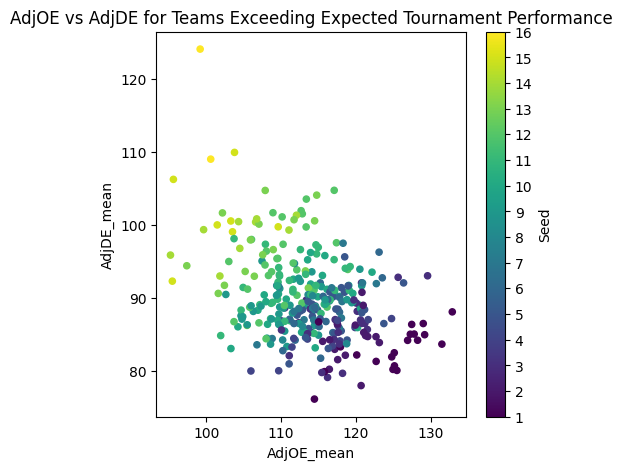

In [10]:
exceed_exp_df = tourney_teams[tourney_teams["ExceedExp"]]
# Color by seed
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(1, 16)
exceed_exp_df["color"] = exceed_exp_df["Seed"].apply(lambda x: cmap(norm(x)))
exceed_exp_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c='color', figsize=(5, 5))
plt.title("AdjOE vs AdjDE for Teams Exceeding Expected Tournament Performance")
# Configure legend for the cmap
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(1, 17), label="Seed")
plt.show()

# Investigate Individual Feature Importance

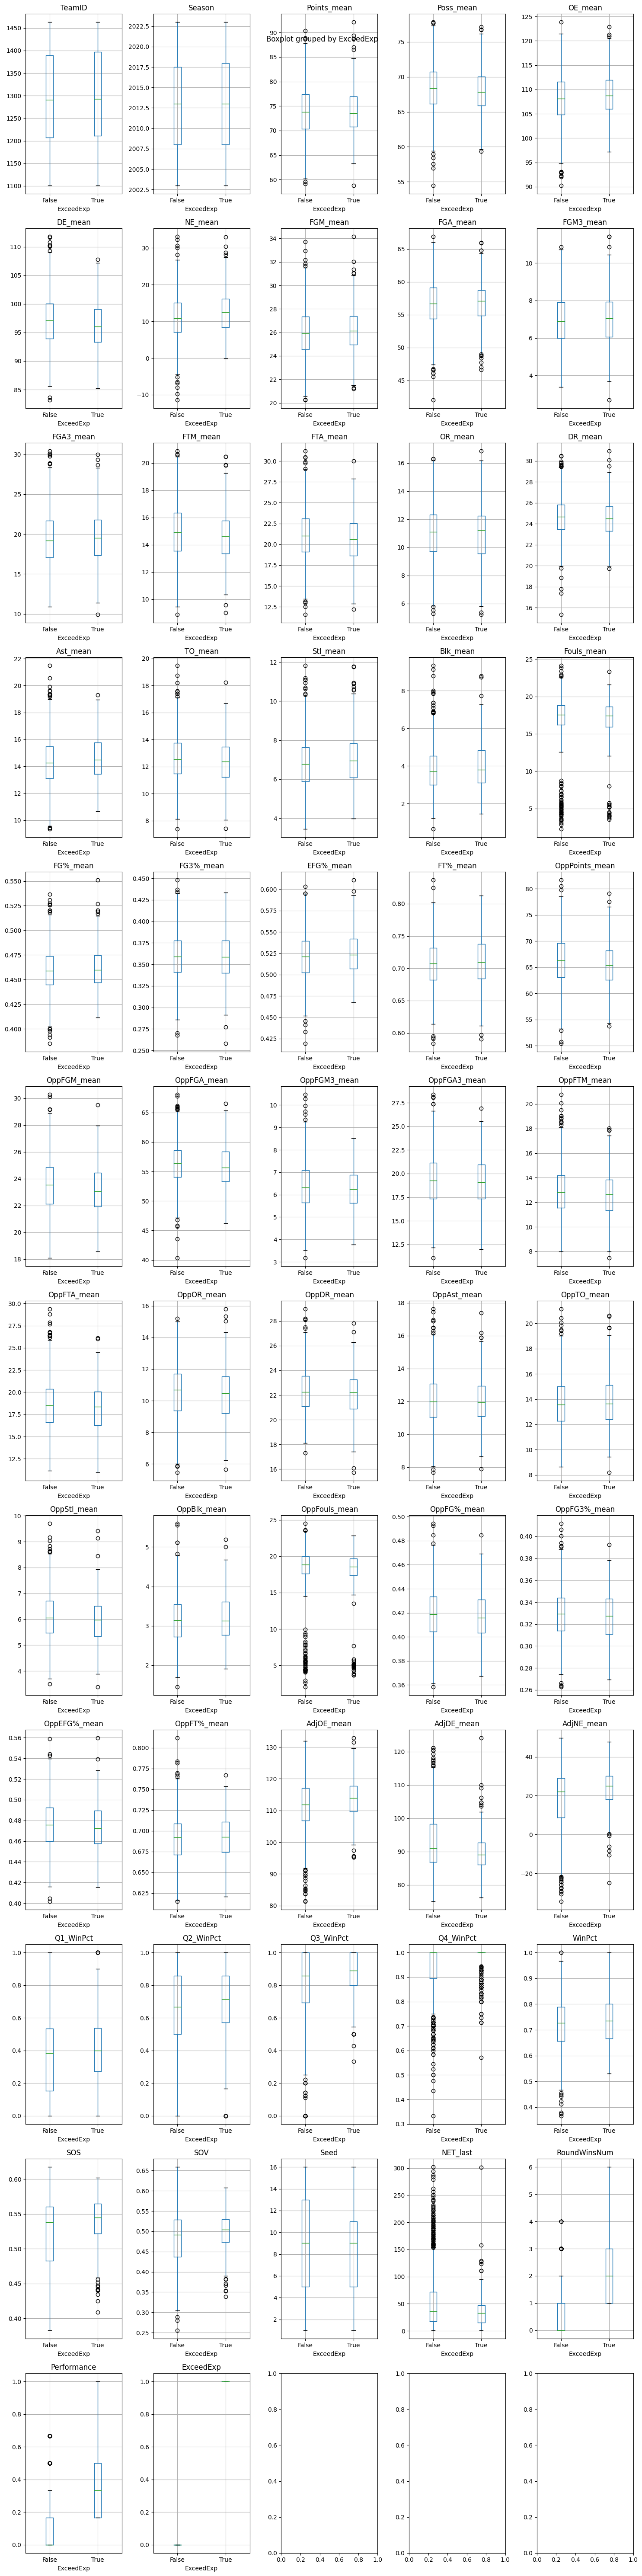

In [11]:
import math
filtered_columns = [col for col in tourney_teams.columns if not col.endswith("_stdev") and col != "ExitRound"]
rows = math.ceil(len(filtered_columns) / 5)
fig, ax = plt.subplots(nrows=rows, ncols=5, figsize=(15, 5*rows))
ax = ax.flatten().tolist()
for i, col in enumerate(filtered_columns):
    try:
        tourney_teams.boxplot(column = col, by = "ExceedExp", ax = ax[i])
        ax[i].set_title(col)
    except IndexError:
        print(f"IndexError: {i} {col}")
fig.tight_layout()
plt.show()

In [12]:
# Import HDBSCAN
from sklearn.cluster import HDBSCAN

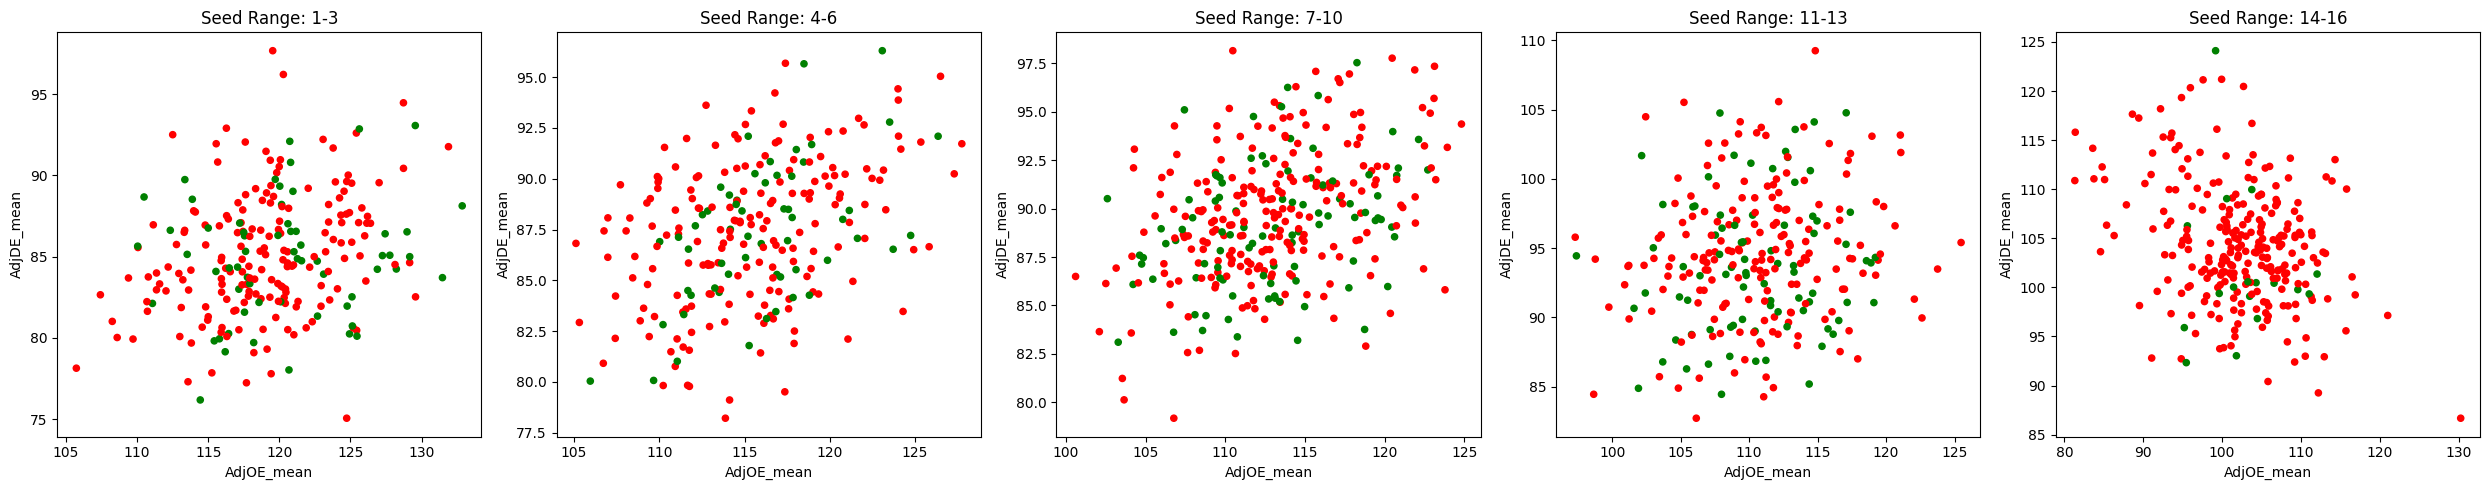

In [13]:
seed_bounds = [(1, 3), (4, 6), (7, 10), (11, 13), (14, 16)]
fig, ax = plt.subplots(1, 5, figsize=(25, 5))
ax = ax.flatten()
for i, (lower, upper) in enumerate(seed_bounds):
    ax[i].set_title(f"Seed Range: {lower}-{upper}")
    seed_df = tourney_teams[(tourney_teams["Seed"] >= lower) & (tourney_teams["Seed"] <= upper)]
    colors = seed_df["ExceedExp"].map({True: "g", False: "r"})
    # Scatter plot of AdjOE vs AdjDE with color by ExceedExpColor
    seed_df.plot(kind='scatter', x='AdjOE_mean', y='AdjDE_mean', c=colors, ax=ax[i])
    
    # Run HDBScan on the data
    hdb = HDBSCAN(min_cluster_size=20)
    # Plot the clusters
    hdb.fit(seed_df[["AdjOE_mean", "AdjDE_mean"]])
fig.tight_layout()



# Setup Datasets for Model Exploration

In [14]:
tourney_teams["ExceedExp"].value_counts()

False    1023
True      313
Name: ExceedExp, dtype: int64

In [15]:
X_COLS = set(tourney_teams.columns.tolist()) - { "ExceedExp", "ExitRound", "RoundWinsNum", "Performance", "Seed" }

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = tourney_teams[list(X_COLS)]
X.fillna(0, inplace=True)
Y = tourney_teams["ExceedExp"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, stratify=Y, shuffle=True)
ss_train = MinMaxScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = MinMaxScaler()
X_test = ss_test.fit_transform(X_test)

# Methods for Feature Selection

In [17]:
SELECT_N_FEATURES = 12

In [18]:
# Basic Feature Selection for Classification
from sklearn.feature_selection import SelectKBest, f_classif

cls_selector = SelectKBest(f_classif, k=SELECT_N_FEATURES)
X_train_selected = cls_selector.fit_transform(X_train, Y_train)
X_test_selected = cls_selector.transform(X_test)

selected_features = X.columns[cls_selector.get_support()]
selected_features

Index(['SOS', 'OppPoints_mean', 'Q2_WinPct', 'AdjDE_mean', 'AdjOE_mean',
       'AdjNE_mean', 'NE_mean', 'FGM_stdev', 'Q3_WinPct', 'Q4_WinPct', 'SOV',
       'NET_last'],
      dtype='object')

In [19]:
# Feature Selection for Regression
from sklearn.feature_selection import SelectKBest, f_regression

reg_selector = SelectKBest(f_regression, k=SELECT_N_FEATURES)
X_train_selected = reg_selector.fit_transform(X_train, Y_train)
X_test_selected = reg_selector.transform(X_test)

selected_features = X.columns[reg_selector.get_support()]
selected_features

Index(['SOS', 'OppPoints_mean', 'Q2_WinPct', 'AdjDE_mean', 'AdjOE_mean',
       'AdjNE_mean', 'NE_mean', 'FGM_stdev', 'Q3_WinPct', 'Q4_WinPct', 'SOV',
       'NET_last'],
      dtype='object')

In [20]:
# L1-based Feature Selection
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.025, penalty="l1", dual=False, max_iter=10000).fit(X_train, Y_train)
model = SelectFromModel(lsvc, prefit=True)
X_train_selected = model.transform(X_train)

selected_features = X.columns[model.get_support()]
selected_features

Index(['AdjDE_mean', 'OppFouls_mean'], dtype='object')

In [21]:
# Tree-based Feature Selection
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, Y_train)
model = SelectFromModel(clf, prefit=True)
X_train_selected = model.transform(X_train)

selected_features = X.columns[model.get_support()]
selected_features

Index(['Fouls_mean', 'SOS', 'OppPoints_mean', 'AdjNE_stdev', 'OE_mean',
       'AdjDE_stdev', 'Points_mean', 'Q2_WinPct', 'OppFG3%_stdev', 'DR_stdev',
       'OppAst_mean', 'AdjDE_mean', 'TeamID', 'AdjOE_mean', 'FTA_mean',
       'OppFG%_stdev', 'AdjNE_mean', 'NE_mean', 'Ast_stdev', 'FGM_stdev',
       'Blk_mean', 'FGM3_mean', 'OppBlk_mean', 'FTA_stdev', 'OppEFG%_stdev',
       'FGM3_stdev', 'OppFGA3_stdev', 'DE_stdev', 'Q3_WinPct', 'Q1_WinPct',
       'DR_mean', 'OE_stdev', 'OppFGM_stdev', 'SOV', 'FGM_mean', 'OppTO_mean',
       'FG%_mean', 'Points_stdev', 'FT%_mean', 'NET_last', 'FT%_stdev',
       'OppStl_stdev', 'OppOR_stdev', 'OppTO_stdev'],
      dtype='object')

In [22]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import xgboost as xgb

models = {
    "Logistic Reg": LogisticRegression(),
    "Ridge": RidgeClassifier(alpha=0.5),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(kernel="poly", degree=3, C=0.1, gamma="auto", max_iter=100000000),
    "LinearSVC": LinearSVC(max_iter=1000000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "XGBoost": xgb.XGBClassifier()
}
model_res = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall"])
for model_name, model in models.items():
    model.fit(X_train, Y_train)
    predictions = model.predict(X_test)
    model_res = model_res.append({
        "Model": model_name,
        "Accuracy":  accuracy_score(predictions, Y_test),
        "Precision": precision_score(predictions, Y_test),
        "Recall":    recall_score(predictions, Y_test, zero_division="warn")
    }, ignore_index=True)
print(model_res)


/Users/andrewgrowney/.pyenv/versions/3.9.10/envs/nlu/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


           Model  Accuracy  Precision    Recall
0   Logistic Reg  0.756219   0.106383  0.416667
1          Ridge  0.736318   0.106383  0.312500
2  Random Forest  0.736318   0.042553  0.200000
3            SVM  0.766169   0.000000  0.000000
4      LinearSVC  0.746269   0.297872  0.437500
5    Naive Bayes  0.567164   0.510638  0.272727
6            KNN  0.696517   0.063830  0.150000
7  Decision Tree  0.706468   0.276596  0.342105
8        XGBoost  0.741294   0.106383  0.333333


# Naive Bayes Feature Importance

In [23]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(models["Naive Bayes"], X_test, Y_test)

nb_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": imps.importances_mean,
    "Std": imps.importances_std
})
nb_importances = nb_importances.sort_values("Importance", ascending=False)
nb_importances

,Feature,Importance,Std
58,NE_stdev,0.004975,0.008325
7,AdjNE_stdev,0.004975,0.004450
89,FT%_stdev,0.004975,0.005450
38,FGM_stdev,0.002985,0.005074
88,OR_stdev,0.002985,0.003980
...,...,...,...
69,SOV,-0.013930,0.015221
86,NET_last,-0.014925,0.016650
33,OppFGM3_stdev,-0.014925,0.008900
41,OppFGM3_mean,-0.014925,0.005450


## Looking at XGB Boost Feature Importance

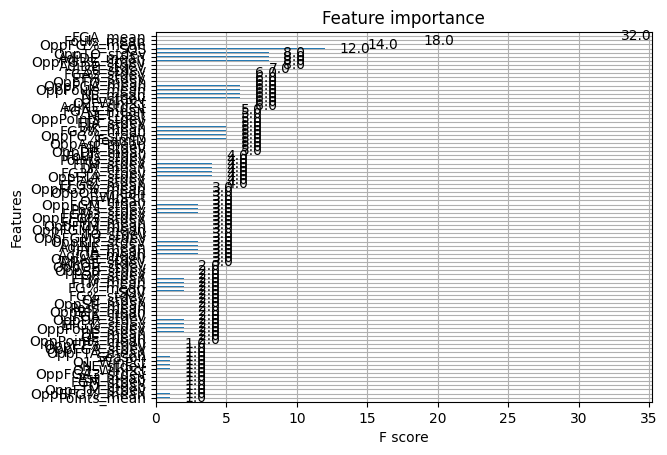

In [24]:
# XGBoost Feature Importance
dtrain = xgb.DMatrix(X_train, label=Y_train, feature_names=X.columns.tolist())
xgb.plot_importance(xgb.train({}, dtrain))
plt.show()

# Predicting Exit Round with Different Basic Regression Models

In [37]:
X.columns

Index(['FGA_mean', 'Fouls_mean', 'EFG%_mean', 'OppFG%_mean', 'SOS',
       'OppDR_mean', 'OppPoints_mean', 'AdjNE_stdev', 'OE_mean', 'AdjDE_stdev',
       'Points_mean', 'Stl_stdev', 'Q2_WinPct', 'OppFG3%_stdev',
       'OppEFG%_mean', 'DR_stdev', 'AdjOE_stdev', 'Blk_stdev', 'OppAst_stdev',
       'DE_mean', 'OppAst_mean', 'AdjDE_mean', 'OppFouls_stdev',
       'OppFTM_stdev', 'TeamID', 'AdjOE_mean', 'FTA_mean', 'OppFG%_stdev',
       'TO_mean', 'AdjNE_mean', 'EFG%_stdev', 'OppBlk_stdev', 'FG3%_mean',
       'OppFGM3_stdev', 'OppDR_stdev', 'TO_stdev', 'NE_mean', 'Ast_stdev',
       'FGM_stdev', 'Blk_mean', 'OppFouls_mean', 'OppFGM3_mean', 'OppFTM_mean',
       'Ast_mean', 'OppFTA_stdev', 'FGA_stdev', 'FGM3_mean', 'OppFGA_mean',
       'OppBlk_mean', 'FTA_stdev', 'OppEFG%_stdev', 'Poss_mean',
       'OppPoints_stdev', 'FGM3_stdev', 'OppFGA3_stdev', 'DE_stdev',
       'FG3%_stdev', 'Q3_WinPct', 'NE_stdev', 'Q4_WinPct', 'Q1_WinPct',
       'OppStl_mean', 'Poss_stdev', 'DR_mean', 'Season',

In [25]:
# Scale features per column
X_scaled = StandardScaler().fit_transform(X)
# Performance
Y_sern = tourney_teams["Performance"]


In [26]:
X.describe()

,FGA_mean,Fouls_mean,EFG%_mean,OppFG%_mean,SOS,OppDR_mean,OppPoints_mean,AdjNE_stdev,OE_mean,AdjDE_stdev,...,NET_last,OppFG3%_mean,OR_stdev,FT%_stdev,OppStl_stdev,FGA3_stdev,OppFT%_mean,OppOR_stdev,OppTO_stdev,FGA3_mean
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,...,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000
mean,56.736032,17.029183,0.522189,0.418410,0.526955,22.325936,66.100498,19.738081,108.285556,12.316945,...,50.962575,0.329160,3.704959,0.111779,2.646429,4.806027,0.690914,3.762608,3.879468,19.484812
std,3.455541,3.267912,0.026435,0.021262,0.044831,1.788598,4.805426,2.732462,4.910225,1.967706,...,51.028347,0.022635,0.628194,0.018508,0.418603,0.767284,0.028129,0.609267,0.676209,3.348609
min,42.035714,2.285714,0.419467,0.358381,0.382979,15.733333,50.428571,11.995339,90.270663,6.635815,...,1.000000,0.262798,1.983310,0.063624,1.578941,2.795120,0.615019,2.161821,2.034426,9.931034
25%,54.483593,16.140476,0.503390,0.404323,0.491226,21.064012,62.902419,17.813580,105.033561,10.891795,...,17.000000,0.313155,3.280509,0.098432,2.351067,4.264585,0.671863,3.335400,3.392586,17.175595
50%,56.825758,17.530331,0.521783,0.418237,0.540650,22.222278,66.015152,19.606864,108.263480,12.115276,...,35.000000,0.328964,3.682729,0.110685,2.632789,4.774993,0.692481,3.754426,3.826871,19.281250
75%,59.035063,18.758621,0.539664,0.432989,0.561461,23.500000,69.241641,21.511058,111.675132,13.514187,...,61.250000,0.343958,4.088014,0.122570,2.915543,5.297892,0.709168,4.169617,4.278875,21.709677
max,66.878788,24.125000,0.610733,0.494292,0.617491,28.969697,81.645161,28.845994,123.829359,19.264335,...,302.000000,0.411663,6.231770,0.204286,4.172899,8.153162,0.811728,5.800320,7.342480,30.400000


In [27]:
Y_sern.describe()

count    1336.000000
mean        0.157186
std         0.221206
min         0.000000
25%         0.000000
50%         0.000000
75%         0.166667
max         1.000000
Name: Performance, dtype: float64

In [35]:
# Predict ExitRoundNum with XGBoost
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_score, RepeatedKFold

reg_models = [
    ("XGBReg", XGBRegressor()),
    ("linear", LinearRegression()),
    ("SGD", SGDRegressor())
]
reg_model_res = pd.DataFrame(columns=["Model", "MAE", "MAE_std"])
for model_name, model in reg_models:
    score = cross_val_score(model, X_scaled, Y_sern, cv=RepeatedKFold(n_splits=10, n_repeats=3, random_state=1))
    reg_model_res = reg_model_res.append({
        "Model": model_name,
        "MAE": score.mean(),
        "MAE_std": score.std()
    }, ignore_index=True)
    model.fit(X_scaled, Y_sern) # Fit the model
    
reg_model_res

,Model,MAE,MAE_std
0,XGBReg,0.226747,0.118364
1,linear,0.286127,0.080644
2,SGD,0.280151,0.066750


In [39]:
ALABAMA = 1104

# Get Alabama's data
alabama_data = X_scaled[X_scaled["TeamID"] == ALABAMA & X_scaled["Season"] == 2024]
print(alabama_data)

reg_models[0][1].predict(alabama_data)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices